In [1]:
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.special as ss
import scipy.integrate as si
import scipy.optimize as so
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.numpy.linalg as jnl
from jax.config import config
config.update("jax_enable_x64", True)

<h1>Forward Problem</h1>

In [20]:
# size of spatial domain
L = 10.0
# number of real space grid points (for plotting)
numx = 1025
# real space grid points (for plotting)
xvec = np.linspace(-L, L, numx)

# number of Fourier basis functions
# n = -numF to n = numF
numfour = 12  # 32

# matrix for converting Fourier representation to real space
fournvec = np.arange(-numfour, numfour + 1) # fournvec=-nfb,...,0,...,nfb
fourtox = np.exp(1j * np.pi * np.outer(fournvec, xvec) / L) / np.sqrt(2 * L)
print('Shape fourtox:', fourtox.shape)

Shape fourtox: (25, 1025)


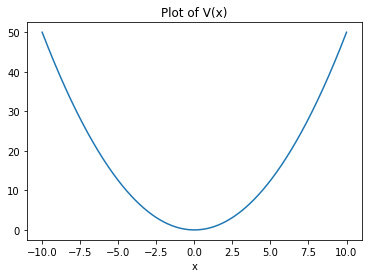

In [3]:
def v(z):
    # harmonic oscillator potential (should be exact for Chebyshev)
    return 0.5 * z**2
    # symmetric double well potential
    # return 2.5e-3 * (z**2 - 25)**2
    # asymmetric double well potential
    # c0 = 4.35; c1 = 9.40e-1; c2 = -3.56e-1; c3 = -4.66e-2
    # c4 = 1.46e-2; c5 = 6.76e-4; c6 = -1.26e-4; c7 = -5.43e-6
    # c8 = 4.12e-7; c9 = 1.65e-8
    # x = z + 0.8
    # return 0.5 * (c0 + c1*x + c2*x**2 + c3*x**3 + c4*x**4 + c5*x**5 \
    #        + c6*x**6 + c7*x**7 + c8*x**8 + c9*x**9)
    # non-polynomial potentials
    # return np.sin(0.4 * z - 1)
    # return np.sin((0.5 * z)**2)
    # return 15 * (-np.cos(z) + np.sin((0.5 * z)**2 - 0.2 * z))
    # soft coulomb potential
    # return -1 / np.sqrt(z**2 + 0.25)

# compute true potential on real space grid for plotting
vxvec = v(xvec)

# plot true potential
plt.plot(xvec, vxvec)
plt.title('Plot of V(x)')
plt.xlabel('x')
plt.show()

In [4]:
# transform potential to Fourier representation

fourvtoep = []
for thisfourn in range(2 * numfour + 1):
    def intgrnd(x):
        return v(x) * np.exp(-1j * np.pi * thisfourn * x / L) / (2 * L)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    fourvtoep.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])
vmattrue = sl.toeplitz(r=fourvtoep, c=np.conj(fourvtoep))

print('Shape vmattrue:', vmattrue.shape)

Shape vmattrue: (25, 25)


Vector L2 Error psi0_0: 5.861156835591512e-06
Vector L-infinity Error psi0_0: 2.231487175188936e-06


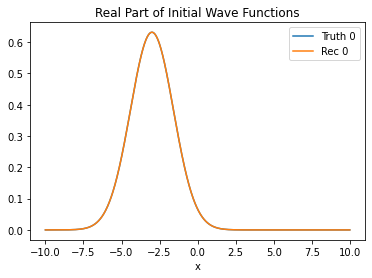

In [5]:
# define initial states and transform to Fourier basis

def psi0_0(x):
    return np.exp(-(x + 3)**2 / 4) * (2.0 / np.pi)**0.25

def psi0_1(x):
    return np.exp(-(x - 3)**2 / 4) * (2.0 / np.pi)**0.25

def psi0_2(x):
    return np.exp(-(x - 6)**2) * (2.0 / np.pi)**0.25

def psi0_3(x):
    return np.exp(-(x + 6)**2) * (2.0 / np.pi)**0.25

def psi0_4(x):
    return np.exp(-x**2) * (2.0 / np.pi)**0.25

def mka0(psi0fn):
    # compute psi0 normalization term
    psi0fn_prob_intgrnd = lambda x: np.abs(psi0fn(x)) ** 2
    psi0fn_norm = np.sqrt(si.quad(psi0fn_prob_intgrnd, -L, L)[0])

    # normalized psi function (for integration)
    norm_psi0fn_fn = lambda x: psi0fn(x) / psi0fn_norm

    # compute the Fourier representation of psi0fn
    norm_psi0fn = []
    for thisfourn in range (numfour + 1):
        def intgrnd(x):
            return norm_psi0fn_fn(x) * np.exp(-1j * np.pi * thisfourn * x / L) / np.sqrt(2 * L)
        def rintgrnd(x):
            return intgrnd(x).real
        def iintgrnd(x):
            return intgrnd(x).imag
        norm_psi0fn.append(si.quad(rintgrnd, -L, L)[0] \
                           + 1j * si.quad(iintgrnd, -L, L)[0])

    a0 = np.concatenate([np.conjugate(np.flipud(norm_psi0fn[1:])), norm_psi0fn])

    normpsi0x = norm_psi0fn_fn(xvec)

    return a0, normpsi0x

# psi0fnvec = [psi0_0, psi0_1, psi0_4]
psi0fnvec = [psi0_0]

a0vec = []
normpsi0xvec = []
normpsi0recxvec = []
for thispsi0fn in psi0fnvec:
    tempa0, tempnormpsi0x = mka0(thispsi0fn)
    a0vec.append(tempa0)
    normpsi0xvec.append(tempnormpsi0x)
    normpsi0recxvec.append(tempa0 @ fourtox)


# check if Fourier representation is close to truth

# plot the real part of the normalized psi0
for i in range(len(normpsi0xvec)):
    print(f'Vector L2 Error psi0_{i}:', nl.norm(normpsi0xvec[i] - normpsi0recxvec[i]))
    print(f'Vector L-infinity Error psi0_{i}:', np.max(np.abs(normpsi0xvec[i] - normpsi0recxvec[i])))
    plt.plot(xvec, normpsi0xvec[i].real, label=f"Truth {i}")
    plt.plot(xvec, normpsi0recxvec[i].real, label=f"Rec {i}")

plt.title('Real Part of Initial Wave Functions')
plt.xlabel('x')
plt.legend()
plt.show()

---
**Forward Propagation**

In [6]:
# Eigendecomposition of Hamiltonian

# kinetic operator in the Fourier representation
# (this is constant for a given system)
kmat = np.diag(np.arange(-numfour, numfour + 1) ** 2 * np.pi ** 2 / (2 * L ** 2))

# Hamiltonian operator in the Fourier representation
hmattrue = kmat + vmattrue

# check if the Hamiltonian matrix is Hermitian
print('hmattrue Hermitian check (should be close to zero):', nl.norm(hmattrue - hmattrue.T.conj()), sep='\n')

# eigen-decomposition of the Hamiltonian matrix
spctrue, stttrue = nl.eigh(hmattrue)

# check if the decomposition diagonalizes the
# Hamiltonian matrix
# if this is close to zero then
# hmat = states @ np.diag(spec) @ np.conj(states).T
print('hmattrue diagonalized check (should be close to zero):', nl.norm(hmattrue @ stttrue - stttrue @ np.diag(spctrue)), sep='\n')

# check if the eigenstates are unitary
print('stttrue unitary check (should be close to zero):', nl.norm(stttrue @ stttrue.T.conj() - np.eye(2 * numfour + 1)), sep='\n')

hmattrue Hermitian check (should be close to zero):
0.0
hmattrue diagonalized check (should be close to zero):
1.0821475850409268e-13
stttrue unitary check (should be close to zero):
6.871102662274836e-15


[0.50000034 1.50001041 2.50014751 3.50127861 4.50753787 5.53192104]


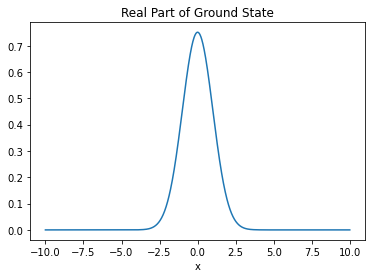

Quick normalization check (should be close to 1):
1.0000000000062454
Accurate normalization check (should be close to 1):
0.9999999999999986


In [7]:
# plot ground state of Eigendecomposition

# find indices that sort eigenvalues
ordering = np.argsort(spctrue)

# print the first few eigenvalues
print(spctrue[ordering[:6]])

# pick out and plot real part of the ground state
groundstate = ordering[0]
wavefn = stttrue[:, groundstate] @ fourtox
plt.plot(xvec, np.real(wavefn))
plt.title('Real Part of Ground State')
plt.xlabel('x')
plt.show()

# quick and dirty check of normalization
print('Quick normalization check (should be close to 1):', np.sum(np.abs(wavefn)**2 * (xvec[1]-xvec[0])), sep='\n')

# this should be a more accurate check of the ground state
# wave functions' normalization
print('Accurate normalization check (should be close to 1):', si.trapezoid(np.abs(wavefn)**2, xvec), sep='\n')

In [8]:
# Propagate

# set time-step size
dt = 1e-2

# set number of time steps
# trajectory length is numts + 1 (initial state + numts steps)
numts = 10  # 100  # 200


# compute propagator matrix
propatrue = stttrue @ np.diag(np.exp(-1j * spctrue * dt)) @ stttrue.conj().T

amattruevec = []
# propagate system starting from initial "a" state
for thisa0 in a0vec:
    tempahatmat = [thisa0.copy()]
    for i in range(numts):
        tempahatmat.append(propatrue @ tempahatmat[-1])
    amattruevec.append(tempahatmat)

amattruevec = np.array(amattruevec)

print('Shape amattruevec:', amattruevec.shape)

print('Done propagating')

Shape amattruevec: (1, 11, 25)
Done propagating


Shape psimatvec: (1, 11, 1025)
psimatvec.shape[2]: 1025
Shape normpsimatvec: (1, 11)
Average Norm of Trajectory 0 (should be close to 1):
0.9999999999993786


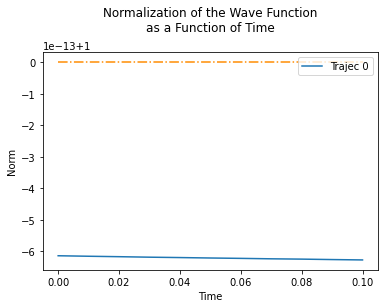

In [9]:
# check if system's state remains normalized for the propagation

psimatvec = amattruevec @ fourtox
print('Shape psimatvec:', psimatvec.shape)
print('psimatvec.shape[2]:', psimatvec.shape[2])

normpsimatvec = si.trapezoid(np.abs(psimatvec)**2, xvec, axis=2)
print('Shape normpsimatvec:', normpsimatvec.shape)

# plot normalization (should be almost flat line at 1)
for i in range(normpsimatvec.shape[0]):
    print(f'Average Norm of Trajectory {i} (should be close to 1):', normpsimatvec[i].sum() / (numts + 1), sep='\n')
    plt.plot(np.arange(numts + 1) * dt, normpsimatvec[i], label=f'Trajec {i}')

plt.hlines(1, 0, numts * dt, linestyles='-.', colors='darkorange', label='_')
plt.title('Normalization of the Wave Function\nas a Function of Time\n')
plt.xlabel('Time')
plt.ylabel('Norm')
plt.legend()
plt.show()

<h1>Inverse Problem</h1>

In [10]:
# code for constructing a toeplitz matrix from the
# Fourier representation
# flat_toep_vec = jnp.concatenate([jnp.flipud(cvrow.conj()), cvrow[1:]])

numtoepelms = 2 * numfour + 1
aa = (-1) * np.arange(0, numtoepelms).reshape(numtoepelms, 1)
bb = [np.arange(numtoepelms - 1, 2 * numtoepelms - 1)]
toepindxmat = np.array(aa + bb)
print(toepindxmat.shape)

(25, 25)


In [13]:
# check if index method makes same vmat
# should be close to 0

print(nl.norm(vmattrue - np.concatenate([np.flipud(np.conj(fourvtoep)), fourvtoep[1:]])[toepindxmat]))

0.0


In [11]:
# convert numpy objects into JAX objects

jaxamattruevec = jnp.stack(amattruevec)
print('Shape jaxamattruevec:', jaxamattruevec.shape)

Shape jaxamattruevec: (1, 11, 25)


In [22]:
# probability training data

# probmattruevec = np.abs(amattruevec @ fourtox)**2

fourprobtoep = []
for thisfourn in range(2 * numfour + 1):
    def intgrnd(x):
        return v(x) * np.exp(-1j * np.pi * thisfourn * x / L) / (2 * L)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    fourvtoep.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])
vmattrue = sl.toeplitz(r=fourvtoep, c=np.conj(fourvtoep))
print(probmattruevec.shape)

(1, 11, 1025)


In [19]:
# objective

slt = 10

thisavec = amattruevec[0, slt]
thisprob = probmattruevec[0, slt]

objective = 0
for j in range(-numfour, numfour+1):
    thissum = 0
    for k in range(-numfour, numfour+1):
        if np.abs(j + k) <= numfour:
            thissum += thisavec[j + k + numfour] * np.conj(thisavec[k + numfour])
    fourprob = (thissum / np.sqrt(2 * L))
    print(fourprob)
    err = np.abs(fourprob - thisprob[j + numfour])**2
    print('err:', err)
    objective += err

print(objective)

(4.9246979380442355e-05+0.00018704220400403171j)
err: 3.741005105525908e-08
(-0.000375210667600882+0.0004638259723610288j)
err: 3.559175778549306e-07
(-0.0016667581694325018-7.856468274117698e-05j)
err: 2.784255293316061e-06
(-0.0023399999014574973-0.00352574893242128j)
err: 1.790651162938932e-05
(0.0033531337641837244-0.009134080619910228j)
err: 9.467458302090783e-05
(0.019488844766937845-0.005629426872359972j)
err: 0.00041145323178500595
(0.03037320922435669+0.023406276141571574j)
err: 0.0014689679393454906
(-0.0015470697874770266+0.06570226505954269j)
err: 0.004320115085689706
(-0.0837388086998422+0.058462423951551615j)
err: 0.010810357601143543
(-0.1362095899198419-0.04639426623532098j)
err: 0.024223351962130706
(-0.05515556989398161-0.17535309036238503j)
err: 0.04106571992802929
(0.12596008621987217-0.17166360366436764j)
err: 0.029518567550677156
(0.2236067977498387+0j)
err: 0.0002590675092692213
(0.12596008621987217+0.17166360366436764j)
err: 0.04409352289601401
(-0.0551555698939

In [39]:
# objective function

def probobj(cff):
    # turn Fourier space coefficients of the potential
    # into vmat for propagation
    vmat = jnp.concatenate([jnp.flipud(jnp.conj(cff)), cff[1:]])[toepindxmat]

    # Hamiltonian operator in the Fourier representation
    hmat = kmat + vmat

    # eigen-decomposition of the Hamiltonian matrix
    spc, stt = jnl.eigh(hmat)

    # compute propagator matrix
    propa = stt @ jnp.diag(np.exp(-1j * spc * dt)) @ stt.conj().T

    amatvec = []
    # propagate system starting from initial "a" state
    for thisa0 in a0vec:
        tempahatmat = [thisa0.copy()]
        for i in range(numts):
            tempahatmat.append(propa @ tempahatmat[-1])
        amatvec.append(tempahatmat)

    amatvec = jnp.array(amatvec)
    print(jnl.norm(amatvec - jnp.array(amattruevec)))

    # compute objective functions
    objective = 0
    for i in range(jaxprobmattruevec.shape[0]):
        thisamat = amatvec[i]
        thisprobmat = jaxprobmattruevec[i]
        for r in range(thisamat.shape[0]):
            thissum = 0
            for j in range(-numfour, numfour+1):
                for k in range(-numfour, numfour+1):
                    if abs(j+k) <= numfour:
                        thissum += thisamat[r, k + j + numfour] * jnp.conj(thisamat[r, k])
                objective += jnp.abs(thissum / jnp.sqrt(2 * L) - thisprobmat[r, j + numfour])**2

    return objective

In [40]:
# check objective with true potential
print(probobj(jnp.array(fourvtoep)))

1.0040633196751477e-13
()
11.736956194549274


In [ ]:
# JAX grad of the objective

In [ ]:
# check grad of objective with true potential

---
**Initialize with perturbed true coefficients**

In [ ]:
seed = 1234  # set to None for random initialization
cfftrub = cfftrue.copy()
cfftrub += 0.25 * np.random.default_rng(seed).normal(size=cfftrue.shape)

In [ ]:
restrubjaxgrad = so.minimize(jitcobjfn, cfftrub, jac=jaxgradcobjfn, tol=1e-12, options={'maxiter': 200, 'disp': True, 'gtol': 1e-15}).x

In [ ]:
def sqrerrorfn(x, cffs):
    return (ss.eval_chebyt(chebnvec, x / L) @ cffs - v(x)) ** 2

print('Continuous L2 Error of Potential using Quadrature Method:', np.sqrt(si.quad(sqrerrorfn, -L, L, args=(cfftrue)))[0], sep='\n')

In [ ]:
print('Objective of the Learned Coefficients:', cobjfn(restrubjaxgrad), sep='\n')
print('Vec L2 Norm of Gradient of the Learned Coefficients:', nl.norm(jaxgradcobjfn(restrubjaxgrad)), sep='\n')

print('Continuous L2 Error of Potential using Quadrature Method:', np.sqrt(si.quad(sqrerrorfn, -L, L, args=(restrubjaxgrad)))[0], sep='\n')

# plot learned vs true
# plt.plot(xvec, chebtox @ cfftrub, label='initial')
plt.plot(xvec, chebtox @ restrubjaxgrad, label='learned')
plt.plot(xvec, vxvec, label='Truth')
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()

---
**Initialize with random coefficients**

In [32]:
seed = 1234  # set to None for random initialization
cffform = np.random.default_rng(seed).uniform(low=-5.0, high=5.0, size=cfftrue.shape)

In [33]:
resform = so.minimize(jitcobjfn, cffform, jac=jaxgradcobjfn, tol=1e-15, options={'maxiter': 1000, 'disp': True, 'gtol': 1e-14}).x

         Current function value: 0.000000
         Iterations: 134
         Function evaluations: 313
         Gradient evaluations: 297


Objective of the Learned Coefficients:
3.225981834017433e-24
Vec L2 Norm of Gradient of the Learned Coefficients:
1.3591848931107718e-12
Continuous L2 Error of Potential using Quadrature Method:
8.808442253066008e-11


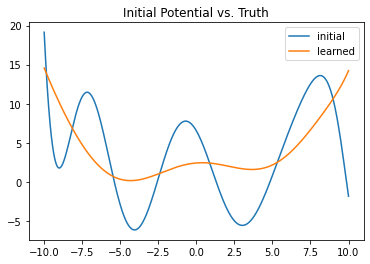

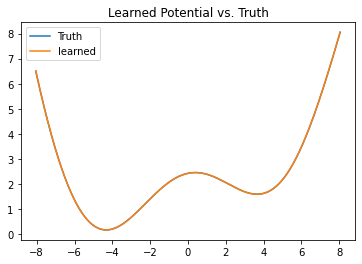

In [34]:
print('Objective of the Learned Coefficients:', cobjfn(resform), sep='\n')
print('Vec L2 Norm of Gradient of the Learned Coefficients:', nl.norm(jaxgradcobjfn(resform)), sep='\n')

print('Continuous L2 Error of Potential using Quadrature Method:', np.sqrt(si.quad(sqrerrorfn, -L, L, args=(resform)))[0], sep='\n')

# plot initial vs learned
plt.plot(xvec, chebtox @ cffform, label='initial')
plt.plot(xvec, chebtox @ resform, label='learned')
plt.title('Initial Potential vs. Truth')
plt.legend()
plt.show()

# plot true vs learned
plt.plot(xvec[100:-100], vxvec[100:-100], label='Truth')
plt.plot(xvec[100:-100], (chebtox @ resform)[100:-100], label='learned')
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()

---
* Forward Problem
    * Computational Variables
    * Potential (real space and Fourier basis)
    * Initial wave function (real and Fourier)
    * Solution to forward problem
* Inverse Problem
    * Training data (prob density - new)
    * Objective (new)
    * JAX grad of objective
    * Solver (optimizer)